In [347]:
import numpy as np
import os
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

def sort(arr: np.array, descend: bool=True) -> tuple:
    """Sort an array and return the sorted array and the index of the sorted array.

    Args:
    -----
        arr: numpy.array, 1-dimensional array to be sorted.
        descend: bool, whether to sort in descending order or not.

    Returns:
    --------
        sorted_arr: numpy.array, the sorted array.
        index: numpy.array, the index of the sorted array.
    """
    assert arr.ndim == 1, "Input array should be 1-dimensional"
    index = np.argsort(arr)[::-1] if descend else np.argsort(arr)
    sorted_arr = arr[index]
    return sorted_arr, index

In [348]:
dir = "../logs/exc_generation"
nPulse  = 256
nSample = 256
assert nSample%2 == 0, "nSample should be even"

folders = os.walk(dir).__next__()[1]

rews   = np.zeros((len(folders)*nPulse))
pulses = np.zeros((len(folders)*nPulse, 32, 2))
for idx in range(len(folders)):
    p = loadmat(os.path.join(dir, folders[idx], 'arrays/pulse300.mat'))
    rew_list = p['rew_list']
    rf_list  = p['rf_list']
    rew_list = np.squeeze(rew_list)
    sorted, index = sort(rew_list, descend=True)
    rews[idx*nPulse   : (idx+1)*nPulse] = sorted[ :nPulse]
    pulses[idx*nPulse : (idx+1)*nPulse] = rf_list[index[ :nPulse], ...]

_,nSample_rf,_= rf_list.shape

sorted, index = sort(rews, descend=True)
result = pulses[index[:nPulse], ...]

# interpolation from 32 to 128
xv, yv = np.meshgrid(np.linspace(1,nPulse,nPulse), np.linspace(1,nSample//2,nSample//2), indexing='ij')
pts = np.concatenate([np.expand_dims(xv, axis=2), np.expand_dims(yv, axis=2)], axis=2)
inter_mag = RegularGridInterpolator((np.linspace(1,nPulse, nPulse), np.linspace(1,nSample//2, nSample_rf)), values=result[:,:,0])
inter_pha = RegularGridInterpolator((np.linspace(1,nPulse, nPulse), np.linspace(1,nSample//2, nSample_rf)), values=result[:,:,1])
mag_l = inter_mag(pts)  
pha_l = inter_pha(pts)
mag_r = np.flip(mag_l, axis=1)
pha_r = np.flip(pha_l, axis=1)
# mirror & concatenate
mag = np.concatenate([mag_l, mag_r], axis=1)
pha = np.concatenate([pha_l, pha_r], axis=1)
result = np.concatenate([np.expand_dims(mag, axis=2), np.expand_dims(pha, axis=2)], axis=2)   # (nPulse, nSample, 2)
savemat(os.path.join(dir, 'seed_rfs.mat'), {'result': result})

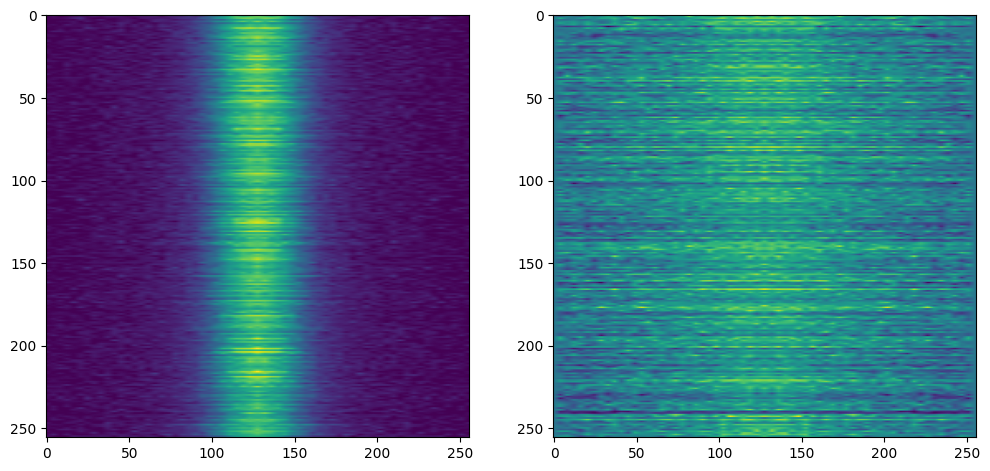

In [349]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(result[..., 0])
axs[1].imshow(result[..., 1])

In [345]:
res = r - result
print(res.max())
print(res.min())

0.0
0.0


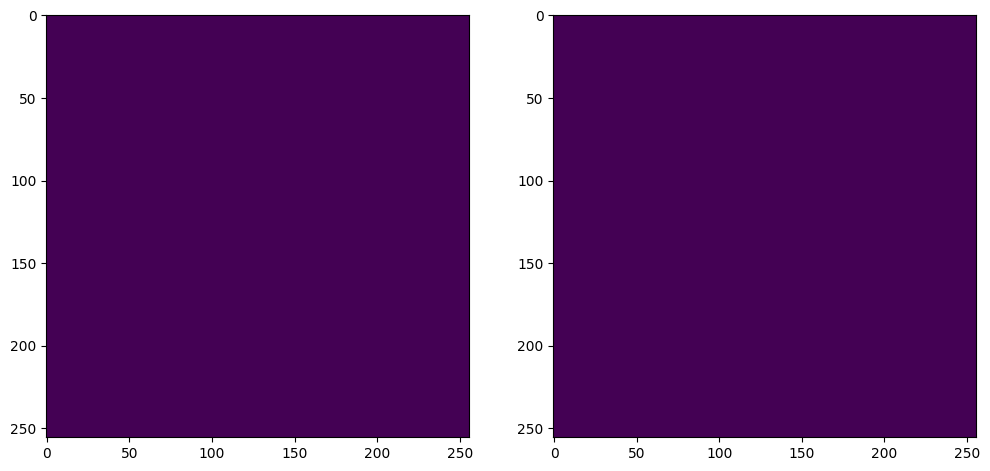

In [346]:
r = loadmat(os.path.join(dir, 'seed_rfs.mat'))['result']
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(res[..., 0])
axs[1].imshow(res[..., 1])

In [33]:
# p['magnitude']
# p['phase']
# p['sar']
# p['rf_list']
# p['mz1']
# p['mz2']
# p['rew']
# p['rew_list']

i = 10
# plt.plot(np.linspace(1,128,32), result[i,:,1])
# plt.plot(np.linspace(1,128,128), pha_l[i,:])
# plt.plot(np.linspace(1,128,128), pha_r[i,:])
plt.plot(np.linspace(1,256,256), pha[i,:])
# plt.plot(np.linspace(1,128,32), result[i,:,0])
plt.plot(np.linspace(1,256,256), mag[i,:])
# plt.plot(np.linspace(1,128,128), mag_l[i,:])
# plt.plot(np.linspace(1,128,128), mag_r[i,:])

(257, 256)